# Create/Load Train-Valid-Test Splits

In [ ]:
import pandas as pd
import numpy as np

metadata = pd.read_csv('bucket/metadata.csv')
metadata.head()

,type,patient,replicate,count_matrix,histology_image,spot_coordinates,tumor_annotation
0,HER2_luminal,BC23287,C1,BC23287_C1_stdata.tsv.gz,HE_BT23287_C1.jpg,spots_BT23287_C1.csv.gz,BC23287_C1_Coords.tsv.gz
1,HER2_luminal,BC23287,C2,BC23287_C2_stdata.tsv.gz,HE_BT23287_C2.jpg,spots_BT23287_C2.csv.gz,BC23287_C2_Coords.tsv.gz
2,HER2_luminal,BC23287,D1,BC23287_D1_stdata.tsv.gz,HE_BT23287_D1.jpg,spots_BT23287_D1.csv.gz,BC23287_D1_Coords.tsv.gz
3,HER2_luminal,BC23450,D2,BC23450_D2_stdata.tsv.gz,HE_BT23450_D2.jpg,spots_BT23450_D2.csv.gz,BC23450_D2_Coords.tsv.gz
4,HER2_luminal,BC23450,E1,BC23450_E1_stdata.tsv.gz,HE_BT23450_E1.jpg,spots_BT23450_E1.csv.gz,BC23450_E1_Coords.tsv.gz


Text(0.5, 0, 'Count')

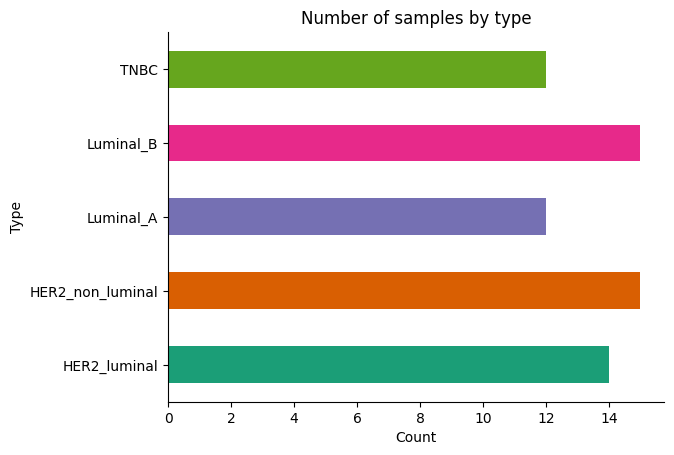

In [ ]:
# @title type

from matplotlib import pyplot as plt
import seaborn as sns
metadata.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Number of samples by type')
plt.ylabel('Type')
plt.xlabel('Count')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_data(metadata_df):
    # Get unique patient IDs and cancer types
    patient_ids = metadata_df['patient'].unique()
    cancer_types = metadata_df['type'].unique()

    # Create a dictionary to store patient IDs for each cancer type
    cancer_patients = {cancer_type: metadata_df[metadata_df['type'] == cancer_type]['patient'].unique()
                       for cancer_type in cancer_types}

    # Randomly select one patient from each cancer type for the test set
    test_patients = [np.random.choice(patients, 1)[0] for patients in cancer_patients.values()]

    # Randomly select one patient from each cancer type for the validation set
    remaining_patients = {cancer_type: [p for p in patients if p not in test_patients]
                          for cancer_type, patients in cancer_patients.items()}
    valid_patients = [np.random.choice(patients, 1)[0] for patients in remaining_patients.values()]

    # Assign remaining patients to the train set
    train_patients = [p for p in patient_ids if p not in test_patients + valid_patients]

    # Split the data into train, validation, and test sets based on patient IDs
    train_df = metadata_df[metadata_df['patient'].isin(train_patients)]
    valid_df = metadata_df[metadata_df['patient'].isin(valid_patients)]
    test_df = metadata_df[metadata_df['patient'].isin(test_patients)]

    return train_df, valid_df, test_df

train_metadata, valid_metadata, test_metadata  = split_data(metadata)

In [ ]:
# print('Train metadata')
# print(79*'-')
# print(f'''
# Size: {len(train_metadata)}
# Distribution of cancer types: {train_metadata.value_counts('type')}
#       ''')
# print(79*'-')
# print('Valid metadata')
# print(79*'-')
# print(f'''
# Size: {len(valid_metadata)}
# Distribution of cancer types: {valid_metadata.value_counts('type')}
#       ''')
# print(79*'-')
# print('Test metadata')
# print(79*'-')
# print(f'''
# Size: {len(test_metadata)}
# Distribution of cancer types: {test_metadata.value_counts('type')}
#       ''')
# print(79*'-')

Train metadata
-------------------------------------------------------------------------------

Size: 38
Distribution of cancer types: type
HER2_non_luminal    9
Luminal_B           9
HER2_luminal        8
Luminal_A           6
TNBC                6
Name: count, dtype: int64
      
-------------------------------------------------------------------------------
Valid metadata
-------------------------------------------------------------------------------

Size: 15
Distribution of cancer types: type
HER2_luminal        3
HER2_non_luminal    3
Luminal_A           3
Luminal_B           3
TNBC                3
Name: count, dtype: int64
      
-------------------------------------------------------------------------------
Test metadata
-------------------------------------------------------------------------------

Size: 15
Distribution of cancer types: type
HER2_luminal        3
HER2_non_luminal    3
Luminal_A           3
Luminal_B           3
TNBC                3
Name: count, dtype: int64

In [ ]:
# train_metadata.to_csv('bucket/train_metadata.csv', index = True)
# valid_metadata.to_csv('bucket/valid_metadata.csv', index = True)
# test_metadata.to_csv('bucket/test_metadata.csv', index = True)

# Preprocessing data

In [ ]:
from typing_extensions import final
from gc import collect
import cv2
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA
import os



def create_mask(spot_indices, st_data_indices):
  '''returns 3 arguments - first is the common indices, and the other two are
  the boolean masks '''
  # Assuming spots_indices and st_data_indices are numpy arrays or lists
  common_indices = st_data_indices.intersection(spot_indices)
  return common_indices

train_metadata = pd.read_csv('bucket/train_metadata.csv', index_col = 0)
valid_metadata = pd.read_csv('bucket/valid_metadata.csv', index_col = 0)
test_metadata = pd.read_csv('bucket/test_metadata.csv', index_col = 0)


# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, pooling = 'avg') #  pooling='avg')

# Choose the layer from which you want to get the features
# Let's try using the last layer before the fully connected layers
model = Model(inputs=base_model.input, outputs=base_model.output)

def preprocess_image(img):
    return preprocess_input(img)

def preprocess_single_image(img):
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)


def extract_features(preprocessed_img, model):
    features = model.predict(preprocessed_img)
    # Flatten the features to fit your embedding size requirement
    # For example, we flatten it and could use PCA or another method to reduce dimensionality if needed

    return features

# Use train_data to train PCA for image embedding
data_path = 'bucket/spots/'
st_data_path = 'bucket/stdata'
image_data_path = 'bucket/images/'

def extract_model_data(metadata, run_name, image_feature_length = 2048, embedding_length = 32):
  try:
    for _, record in metadata.iterrows():
      spot_data = pd.read_csv(os.path.join(data_path, record['spot_coordinates']),index_col = 0)
      # match common indices
      spot_indices = spot_data.index
      st_data_indices = pd.read_csv(f'bucket/stdata/{record["count_matrix"]}', sep = '\t', usecols = [0], index_col = 0).index
      spot_mask  =  create_mask(spot_indices, st_data_indices)
      spot_data = spot_data.loc[spot_mask]
      # get image data
      image = cv2.imread(os.path.join(image_data_path, record['histology_image'].replace('.jpg','.tif')), cv2.IMREAD_UNCHANGED)
      print(f"Reading image for Patient: {record['patient']}, Section: {record['replicate']}")
      img_windows = []
      for _ , spot in spot_data.iterrows():
        start_x = round(spot['X']) - 112
        start_y = round(spot['Y']) - 112

        window = image[start_y:start_y + 224, start_x:start_x + 224]
        preprocessed_window = preprocess_image(window)
        img_windows.append(preprocessed_window)
      img_windows = np.array(img_windows)
      features = extract_features(img_windows, model)

      # get neighbor data
      adj_embedding = pd.read_csv(f"bucket/svd/svd_{record['patient']}_{record['replicate']}.csv",header=None).to_numpy()
      assert len(adj_embedding) == len(spot_data)


      # Create dataframes
      df_index = pd.MultiIndex.from_tuples(product([record['patient']], [record['replicate']], spot_data.index),
                                           names = ['Patient', 'Replicate', 'Index']) # create index
      column_names = [f'img_feature_{i}' for i in range(image_feature_length)]
      image_df = pd.DataFrame(index = df_index, columns = column_names)
      image_df[column_names] = features

      adj_column_names = [f'adj_feature_{i}' for i in range(embedding_length)]
      adj_df = pd.DataFrame(index=df_index, columns = adj_column_names)
      adj_df[adj_column_names] = adj_embedding

      # Saving
      image_loc = f"bucket/datasets/{run_name}/preprocessed_img" # index matching done
      adj_loc = f"bucket/datasets/{run_name}/aligned_svd_features" # index matching done
      if not os.path.exists(image_loc):
        os.makedirs(image_loc)
      if not os.path.exists(adj_loc):
        os.makedirs(adj_loc)

      # with open(f"{image_loc}/{record['patient']}_{record['replicate']}_img_features.npy", 'wb') as f:
      #   np.save(f, features)
      image_df.to_csv(f"{image_loc}/{record['patient']}_{record['replicate']}_img_features.csv")
      adj_df.to_csv(f"{adj_loc}/{record['patient']}_{record['replicate']}_adj_features.csv")
  except Exception as e:
    print(record['patient'], record['replicate'])
    raise(e)
  finally:
    print('Data Extraction complete.')



extract_model_data(train_metadata, run_name = 'simple_baseline')
extract_model_data(valid_metadata, run_name = 'simple_baseline')
extract_model_data(test_metadata, run_name = 'simple_baseline')


Reading image for Patient: BC23287, Section: C1
8/8 [==============================] - 8s 889ms/step
Reading image for Patient: BC23287, Section: C2
11/11 [==============================] - 10s 833ms/step
Reading image for Patient: BC23287, Section: D1
12/12 [==============================] - 10s 843ms/step
Reading image for Patient: BC23901, Section: C2
10/10 [==============================] - 8s 816ms/step
Reading image for Patient: BC23901, Section: D1
10/10 [==============================] - 8s 829ms/step
Reading image for Patient: BC23944, Section: D2
13/13 [==============================] - 12s 885ms/step
Reading image for Patient: BC23944, Section: E1
14/14 [==============================] - 12s 845ms/step
Reading image for Patient: BC23944, Section: E2
13/13 [==============================] - 11s 855ms/step
Reading image for Patient: BC23567, Section: D2
19/19 [==============================] - 17s 873ms/step
Reading image for Patient: BC23567, Section: E1
18/18 [==============

## KNN Image Preprocessing

In [ ]:
# Goal: Create kNN based image embedding
## Read adjacency matrix
import anndata
from tqdm import tqdm
patient = 'BC23209'
replicate = 'C1'

train_metadata = pd.read_csv('bucket/train_metadata.csv', index_col = 0)
valid_metadata = pd.read_csv('bucket/valid_metadata.csv', index_col = 0)
test_metadata = pd.read_csv('bucket/test_metadata.csv', index_col = 0)

metadata = train_metadata.copy()
image_loc = train_metadata
# start
def knn_image_processing(metadata, run_name):

  out_loc = f'bucket/datasets/{run_name}/knn_preprocessed_img'
  if not os.path.exists(out_loc):
    os.makedirs(out_loc)

  for _ , record in metadata.iterrows():
    patient = record['patient']
    replicate = record['replicate']
    print(f'Pooling neighbor images for Patient: {patient}, Replicate: {replicate}')
    # start
    image = pd.read_csv(f'bucket/datasets/{run_name}/preprocessed_img/{patient}_{replicate}_img_features.csv', index_col = [0,1,2])
    adata = anndata.read_h5ad(f'bucket/anndata/{patient}_{replicate}.h5ad')
    labels = image.loc[(patient, replicate)].index
    adata = adata[labels] # subset to required indices
    distances = adata.obsp['distances']
    # index matcher
    indices = adata.obs_names.get_indexer(labels)
    l2i_mapper = {label:index for label, index in  zip(labels, indices)}
    i2l_mapper = {index:label for label, index in  zip(labels, indices)}
    pooled_dataframe = image.copy()
    for i in tqdm(range(len(labels))):
      label = labels[i]
      index = adata.obs_names.get_loc(label)
      neighbor_indices = distances[index].nonzero()[1]
      neighbor_labels = pd.Index([i2l_mapper[i] for i in neighbor_indices])
      neighbor_images = image.loc[patient, replicate, neighbor_labels]
      pooled_dataframe.loc[patient, replicate, label] = neighbor_images.mean(axis = 0)
    pooled_dataframe.to_csv(f'{out_loc}/{patient}_{replicate}_img_features.csv')

knn_image_processing(train_metadata, 'knn_pooling')
knn_image_processing(valid_metadata, 'knn_pooling')
knn_image_processing(test_metadata,  'knn_pooling')


Pooling neighbor images for Patient: BC23287, Replicate: C1


100%|██████████| 256/256 [00:01<00:00, 178.74it/s]


Pooling neighbor images for Patient: BC23287, Replicate: C2


100%|██████████| 334/334 [00:01<00:00, 180.08it/s]


Pooling neighbor images for Patient: BC23287, Replicate: D1


100%|██████████| 357/357 [00:02<00:00, 173.03it/s]


Pooling neighbor images for Patient: BC23901, Replicate: C2


100%|██████████| 292/292 [00:01<00:00, 179.34it/s]


Pooling neighbor images for Patient: BC23901, Replicate: D1


100%|██████████| 297/297 [00:01<00:00, 177.88it/s]


Pooling neighbor images for Patient: BC23944, Replicate: D2


100%|██████████| 414/414 [00:02<00:00, 181.86it/s]


Pooling neighbor images for Patient: BC23944, Replicate: E1


100%|██████████| 423/423 [00:02<00:00, 185.33it/s]


Pooling neighbor images for Patient: BC23944, Replicate: E2


100%|██████████| 403/403 [00:02<00:00, 165.85it/s]


Pooling neighbor images for Patient: BC23567, Replicate: D2


100%|██████████| 587/587 [00:03<00:00, 153.63it/s]


Pooling neighbor images for Patient: BC23567, Replicate: E1


100%|██████████| 572/572 [00:02<00:00, 191.19it/s]


Pooling neighbor images for Patient: BC23567, Replicate: E2


100%|██████████| 570/570 [00:02<00:00, 220.19it/s]


Pooling neighbor images for Patient: BC23903, Replicate: C1


100%|██████████| 441/441 [00:02<00:00, 190.88it/s]


Pooling neighbor images for Patient: BC23903, Replicate: C2


100%|██████████| 468/468 [00:02<00:00, 203.62it/s]


Pooling neighbor images for Patient: BC23903, Replicate: D1


100%|██████████| 464/464 [00:03<00:00, 139.65it/s]


Pooling neighbor images for Patient: BC24044, Replicate: D2


100%|██████████| 614/614 [00:02<00:00, 209.21it/s]


Pooling neighbor images for Patient: BC24044, Replicate: E1


100%|██████████| 603/603 [00:02<00:00, 208.51it/s]


Pooling neighbor images for Patient: BC24044, Replicate: E2


100%|██████████| 511/511 [00:02<00:00, 192.12it/s]


Pooling neighbor images for Patient: BC23269, Replicate: C1


100%|██████████| 434/434 [00:02<00:00, 180.60it/s]


Pooling neighbor images for Patient: BC23269, Replicate: C2


100%|██████████| 435/435 [00:02<00:00, 204.63it/s]


Pooling neighbor images for Patient: BC23269, Replicate: D1


100%|██████████| 433/433 [00:01<00:00, 221.64it/s]


Pooling neighbor images for Patient: BC23272, Replicate: D2


100%|██████████| 565/565 [00:02<00:00, 228.17it/s]


Pooling neighbor images for Patient: BC23272, Replicate: E1


100%|██████████| 578/578 [00:02<00:00, 203.85it/s]


Pooling neighbor images for Patient: BC23272, Replicate: E2


100%|██████████| 548/548 [00:02<00:00, 241.51it/s]


Pooling neighbor images for Patient: BC23270, Replicate: D2


100%|██████████| 284/284 [00:01<00:00, 275.32it/s]


Pooling neighbor images for Patient: BC23270, Replicate: E1


100%|██████████| 283/283 [00:01<00:00, 239.39it/s]


Pooling neighbor images for Patient: BC23270, Replicate: E2


100%|██████████| 284/284 [00:01<00:00, 235.47it/s]


Pooling neighbor images for Patient: BC23508, Replicate: D2


100%|██████████| 478/478 [00:01<00:00, 263.10it/s]


Pooling neighbor images for Patient: BC23508, Replicate: E1


100%|██████████| 473/473 [00:01<00:00, 245.42it/s]


Pooling neighbor images for Patient: BC23508, Replicate: E2


100%|██████████| 504/504 [00:02<00:00, 247.07it/s]


Pooling neighbor images for Patient: BC23895, Replicate: C1


100%|██████████| 498/498 [00:02<00:00, 243.99it/s]


Pooling neighbor images for Patient: BC23895, Replicate: C2


100%|██████████| 454/454 [00:01<00:00, 244.35it/s]


Pooling neighbor images for Patient: BC23895, Replicate: D1


100%|██████████| 518/518 [00:02<00:00, 243.31it/s]


Pooling neighbor images for Patient: BC23288, Replicate: D2


100%|██████████| 464/464 [00:01<00:00, 239.54it/s]


Pooling neighbor images for Patient: BC23288, Replicate: E1


100%|██████████| 480/480 [00:01<00:00, 253.66it/s]


Pooling neighbor images for Patient: BC23288, Replicate: E2


100%|██████████| 478/478 [00:01<00:00, 252.15it/s]


Pooling neighbor images for Patient: BC23377, Replicate: C1


100%|██████████| 597/597 [00:02<00:00, 203.47it/s]


Pooling neighbor images for Patient: BC23377, Replicate: C2


100%|██████████| 687/687 [00:03<00:00, 224.56it/s]


Pooling neighbor images for Patient: BC23377, Replicate: D1


100%|██████████| 601/601 [00:02<00:00, 247.99it/s]


Pooling neighbor images for Patient: BC23450, Replicate: D2


100%|██████████| 316/316 [00:01<00:00, 275.29it/s]


Pooling neighbor images for Patient: BC23450, Replicate: E1


100%|██████████| 301/301 [00:01<00:00, 228.41it/s]


Pooling neighbor images for Patient: BC23450, Replicate: E2


100%|██████████| 318/318 [00:01<00:00, 214.75it/s]


Pooling neighbor images for Patient: BC23810, Replicate: D2


100%|██████████| 691/691 [00:02<00:00, 238.79it/s]


Pooling neighbor images for Patient: BC23810, Replicate: E1


100%|██████████| 695/695 [00:03<00:00, 224.75it/s]


Pooling neighbor images for Patient: BC23810, Replicate: E2


100%|██████████| 713/713 [00:03<00:00, 204.74it/s]


Pooling neighbor images for Patient: BC24223, Replicate: D2


100%|██████████| 368/368 [00:01<00:00, 209.41it/s]


Pooling neighbor images for Patient: BC24223, Replicate: E1


100%|██████████| 362/362 [00:01<00:00, 214.50it/s]


Pooling neighbor images for Patient: BC24223, Replicate: E2


100%|██████████| 363/363 [00:01<00:00, 230.32it/s]


Pooling neighbor images for Patient: BC23277, Replicate: D2


100%|██████████| 506/506 [00:02<00:00, 234.69it/s]


Pooling neighbor images for Patient: BC23277, Replicate: E1


100%|██████████| 513/513 [00:02<00:00, 219.97it/s]


Pooling neighbor images for Patient: BC23277, Replicate: E2


100%|██████████| 566/566 [00:02<00:00, 227.97it/s]


Pooling neighbor images for Patient: BC23803, Replicate: D2


100%|██████████| 402/402 [00:01<00:00, 254.16it/s]


Pooling neighbor images for Patient: BC23803, Replicate: E1


100%|██████████| 340/340 [00:01<00:00, 235.64it/s]


Pooling neighbor images for Patient: BC23803, Replicate: E2


100%|██████████| 421/421 [00:01<00:00, 223.00it/s]


Pooling neighbor images for Patient: BC24220, Replicate: D2


100%|██████████| 432/432 [00:01<00:00, 257.25it/s]


Pooling neighbor images for Patient: BC24220, Replicate: E1


100%|██████████| 428/428 [00:01<00:00, 246.21it/s]


Pooling neighbor images for Patient: BC24220, Replicate: E2


100%|██████████| 437/437 [00:01<00:00, 235.44it/s]


Pooling neighbor images for Patient: BC24105, Replicate: C1


100%|██████████| 325/325 [00:01<00:00, 244.16it/s]


Pooling neighbor images for Patient: BC24105, Replicate: C2


100%|██████████| 297/297 [00:01<00:00, 221.62it/s]


Pooling neighbor images for Patient: BC24105, Replicate: D1


100%|██████████| 338/338 [00:01<00:00, 246.16it/s]


Pooling neighbor images for Patient: BC23268, Replicate: C1


100%|██████████| 435/435 [00:01<00:00, 250.64it/s]


Pooling neighbor images for Patient: BC23268, Replicate: C2


100%|██████████| 498/498 [00:02<00:00, 235.29it/s]


Pooling neighbor images for Patient: BC23268, Replicate: D1


100%|██████████| 492/492 [00:01<00:00, 249.11it/s]


Pooling neighbor images for Patient: BC23506, Replicate: C1


100%|██████████| 489/489 [00:01<00:00, 251.05it/s]


Pooling neighbor images for Patient: BC23506, Replicate: C2


100%|██████████| 502/502 [00:02<00:00, 214.51it/s]


Pooling neighbor images for Patient: BC23506, Replicate: D1


100%|██████████| 482/482 [00:02<00:00, 236.00it/s]


Pooling neighbor images for Patient: BC23209, Replicate: C1


100%|██████████| 294/294 [00:01<00:00, 229.64it/s]


Pooling neighbor images for Patient: BC23209, Replicate: C2


100%|██████████| 318/318 [00:01<00:00, 242.80it/s]


Pooling neighbor images for Patient: BC23209, Replicate: D1


100%|██████████| 331/331 [00:02<00:00, 149.04it/s]


# Creating Embeddings

## Simple Image Embedding

In [ ]:
from sklearn.decomposition import PCA
def create_embedding(train_metadata, run_name, input_loc, embedding_length = 32):
  '''
  ONLY USE TRAIN METADATA.
  Images in input_loc must follow convention {patient}_{replicate}_img_features.csv
  '''
  combined_df = []
  print('Concatenating train images together')
  for i in tqdm(range(train_metadata.shape[0]), desc = 'Sample Loop'):
    patient = train_metadata.iloc[i]['patient']
    replicate = train_metadata.iloc[i]['replicate']
    img_features = pd.read_csv(f'{input_loc}/{patient}_{replicate}_img_features.csv', index_col = [0,1,2])
    combined_df.append(img_features)
  train_features = pd.concat(combined_df)
  # Initialize PCA to reduce the features to your desired size, e.g., 128
  pca = PCA(n_components=32, svd_solver = 'randomized')

  # Fit PCA on the extracted features
  train_features_img_embed = pca.fit_transform(train_features)
  print("Reduced features shape:", train_features_img_embed.shape)
  return pca


fit_pca = create_embedding(train_metadata,
                                  'simple_baseline',
                                  f'bucket/datasets/simple_baseline/preprocessed_img',
                                  )
from joblib import dump, load
dump(fit_pca, 'bucket/models/simple_baseline/image_pca_resnet_32.joblib')
# load pca using the following command:
loaded_pca = load('bucket/models/simple_baseline/image_pca_resnet_32.joblib')


Concatenating train images together


Sample Loop: 100%|██████████| 38/38 [00:08<00:00,  4.72it/s]


Reduced features shape: (17682, 32)


In [ ]:
knn_pca.transform(train_features)

array([[-1.61001614e+01,  4.59344789e+00,  4.12188237e+00, ...,
         1.69845529e+00, -1.33225487e+00,  5.68951770e-01],
       [-2.28747952e+01,  1.17296147e+01,  1.18606430e+01, ...,
         3.34784507e+00, -8.97818246e-01,  8.92436724e-01],
       [-2.03480940e+01,  1.40850904e+01,  1.48628998e+01, ...,
         2.99010011e+00, -2.52594282e+00,  1.81458728e-02],
       ...,
       [-1.17983186e+01, -7.46038940e+00, -2.31390469e+00, ...,
         1.09539159e+00, -5.61061106e+00,  5.92662463e-01],
       [ 1.75073854e+01,  9.85812499e+00,  6.73077221e-01, ...,
         1.48291245e+00, -6.93189744e-02, -1.17534554e+00],
       [ 1.59943584e+01,  1.34764925e+01,  6.95774905e-01, ...,
         6.39999819e-01, -1.38462150e+00,  9.24122188e-01]])

## KNN Image Embedding

In [ ]:
knn_pca = create_embedding(train_metadata,
                           'knn_pooling',
                           f'bucket/datasets/knn_pooling/knn_preprocessed_img'
                           )
dump(knn_pca, 'bucket/models/knn_pooling/image_pca_resnet_32.joblib')
knn_pca = load('bucket/models/knn_pooling/image_pca_resnet_32.joblib')


Concatenating train images together


Sample Loop: 100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


Reduced features shape: (17682, 32)


# Modeling

### Common Functions

In [ ]:
from joblib import dump, load
import pandas as pd
import numpy as np
# from tdqm import tqdm
def get_X(metadata, img_loc, adj_loc, pca_loc, add_intercept = True):
  loaded_pca = load(pca_loc)
  img_all = []
  adj_all = []
  with tqdm(range(metadata.shape[0]), desc = 'Loading data') as pbar:
    for i, record in metadata.iterrows():
      patient, replicate = record[['patient','replicate']]
      img_features = pd.read_csv(f'{img_loc}/{patient}_{replicate}_img_features.csv', index_col = [0,1,2])
      img_embedding = pd.DataFrame(loaded_pca.transform(img_features),
                                   index = img_features.index,
                                   columns = [f'img_feature_{j}' for j in range(loaded_pca.n_components)]
                                   ) # no fitting
      adj_embedding = pd.read_csv(f'{adj_loc}/{patient}_{replicate}_adj_features.csv', index_col = [0,1,2])
      img_all.append(img_embedding)
      adj_all.append(adj_embedding)
      pbar.update(1)
  features = pd.concat([pd.concat(img_all), pd.concat(adj_all)],axis = 1)
  if add_intercept:
    features.insert(0, 'bias', 1)
  return features

def get_y(metadata, top_genes_loc):
  top_genes = pd.read_csv(top_genes_loc, header = None)[0].tolist()
  # Create target dataset
  y = []
  with tqdm(range(metadata.shape[0]), desc = 'Loading y-labels') as pbar:
    for i, record in metadata.iterrows():
      type_i, patient, replicate = record['type'], record['patient'], record['replicate']
      df_expression = pd.read_csv(f'bucket/stdata/{patient}_{replicate}_stdata.tsv.gz', sep='\t', index_col=0, compression='gzip')[top_genes]
      # Read the .tsv.gz file directly from GCS bucket into a pandas DataFrame
      df_coordinates = pd.read_csv(f'bucket/spots/{record["spot_coordinates"]}', sep=',', index_col=0, compression='gzip')
      # Filter DataFrames to include only common labels
      common_labels = df_expression.index.intersection(df_coordinates.index)
      # final gene_expressison
      gene_expression = df_expression.loc[common_labels, :].to_numpy()
      y.append(gene_expression)
      pbar.update()
  return np.concatenate(y)


def get_X_y(metadata, img_loc, adj_loc, pca_loc, top_genes_loc):

  # for obtaining y
  top_genes = pd.read_csv(top_genes_loc, header=None)[0].tolist()

  loaded_pca = load(pca_loc)
  img_all = []
  adj_all = []
  exp_data = []

  with tqdm(range(metadata.shape[0]), desc = 'Loading data') as pbar:
      for i, record in metadata.iterrows():
          patient, replicate = record[['patient', 'replicate']]

          # create the features from image and adjacency dataframes
          img_features = pd.read_csv(f'{img_loc}/{patient}_{replicate}_img_features.csv', index_col=[0, 1, 2])
          img_embedding = pd.DataFrame(loaded_pca.transform(img_features),
                                        index=img_features.index,
                                        columns=[f'img_feature_{j}' for j in range(loaded_pca.n_components)]
                                        )  # no fitting
          adj_embedding = pd.read_csv(f'{adj_loc}/{patient}_{replicate}_adj_features.csv', index_col=[0, 1, 2])
          img_all.append(img_embedding)
          adj_all.append(adj_embedding)

          # Now create the gene expression dataframe with spot information
          # Load gene expression data
          df_expression = pd.read_csv(f'bucket/stdata/{patient}_{replicate}_stdata.tsv.gz', sep='\t', index_col=0, compression='gzip')[top_genes]
          adata = anndata.read_h5ad(f'bucket/anndata/{patient}_{replicate}.h5ad')
          # df_expression = pd.DataFrame(adata.X, columns = adata.var_names, index = adata.obs_names)[top_genes]
          df_coordinates = pd.read_csv(f'bucket/spots/{record["spot_coordinates"]}', sep=',', index_col=0, compression='gzip')

          # Find common labels (spot IDs)
          common_labels = df_expression.index.intersection(df_coordinates.index)
          # Adjusted to ensure indexing consistency
          # The trick here is to ensure df_expression is correctly indexed before appending
          df_expression_filtered = df_expression.loc[common_labels]
          df_expression_filtered = (df_expression_filtered
                                    .assign(Patient=patient, Replicate=replicate)
                                    .set_index(['Patient', 'Replicate'],
                                                append=True)
                                      .reorder_levels(['Patient', 'Replicate', df_expression_filtered.index.name]))

          exp_data.append(df_expression_filtered)

          pbar.update(1)


  features = pd.concat([pd.concat(img_all), pd.concat(adj_all)], axis=1)
  y = pd.concat(exp_data)

  return features, y


import numpy as np
import pandas as pd
from scipy import stats

def pearson_correlation(y_true, y_pred):
    return stats.pearsonr(y_true, y_pred)[0]

def spearman_correlation(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred)[0]

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r_squared(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)



# Assuming y_true and y_pred are the DataFrames with true and predicted gene expression data
def get_performance(y_true, y_pred):
  metrics = []
  with tqdm(range(len(y_true.columns)), 'Assessing model performance by gene') as pbar:
    for gene in y_true.columns:
        y_true_gene = y_true[gene]
        y_pred_gene = y_pred[gene]

        pcc = pearson_correlation(y_true_gene, y_pred_gene)
        srcc = spearman_correlation(y_true_gene, y_pred_gene)
        mse = mean_squared_error(y_true_gene, y_pred_gene)
        mae = mean_absolute_error(y_true_gene, y_pred_gene)
        r2 = r_squared(y_true_gene, y_pred_gene)

        metrics.append([gene, pcc, srcc, mse, mae, r2])
        pbar.update()

  # performance by gene
  metrics_df = pd.DataFrame(metrics, columns=['Gene', 'PCC', 'SRCC', 'MSE', 'MAE', 'R2']).set_index('Gene')
  overall_metrics_df = metrics_df.mean()
  return metrics_df, overall_metrics_df


# Save models
def save_models(train_y, train_pred, valid_y, valid_pred, models, run_name, sub_run_name):
  if not os.path.exists(f'bucket/models/{run_name}/{sub_run_name}/predictions'):
    os.makedirs(f'bucket/models/{run_name}/{sub_run_name}/predictions')
  if not os.path.exists(f'bucket/models/{run_name}/{sub_run_name}/gene_models'):
    os.makedirs(f'bucket/models/{run_name}/{sub_run_name}/gene_models')
  for i, gene in enumerate(models):
    models[gene].save(f'bucket/models/{run_name}/{sub_run_name}/gene_models/gene_{gene}_nb.pickle')
  # Save predictions and truth
  train_y.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/train_y.csv')
  train_pred.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/train_predictions.csv')
  valid_y.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/valid_y.csv')
  valid_pred.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/valid_predictions.csv')
  print('Saved models and predictions')

## Linear Baseline

### Get model data

In [ ]:
#import pandas as pd
from tqdm import tqdm
import anndata
train_metadata = pd.read_csv('bucket/train_metadata.csv', index_col = 0)
valid_metadata = pd.read_csv('bucket/valid_metadata.csv', index_col = 0)
test_metadata = pd.read_csv('bucket/test_metadata.csv', index_col = 0)

run_name = 'simple_baseline'
img_loc = f'bucket/datasets/{run_name}/preprocessed_img'
adj_loc= f'bucket/datasets/{run_name}/aligned_svd_features'
pca_loc = f'bucket/models/{run_name}/image_pca_resnet_32.joblib'
top_genes_loc = f'bucket/top_250_genes_new.txt'



train_X, train_y_full = get_X_y(train_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)
valid_X, valid_y_full = get_X_y(valid_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)
test_X, test_y_full = get_X_y(test_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)

Loading data: 100%|██████████| 15/15 [02:07<00:00,  8.47s/it]


### Negative Binomial (With Alpha = 1.0)

In [ ]:
import pandas as pd
import statsmodels.api as sm
sub_run_name = 'simple_nb_no_alpha_est'

# Ensure train_X and valid_X have a constant column for the intercept
X_train_const = sm.add_constant(train_X)
X_valid_const = sm.add_constant(valid_X)
X_test_const = sm.add_constant(test_X)

# Initialize a dictionary to store models (optional) and another for predictions
models = {}  # Optional: Store each gene's model if needed for future reference
valid_predictions = {}
train_predictions = {}
test_predictions = {}
with tqdm(range(len(train_y_full.columns)), desc='Training Models') as pbar:
  for gene in train_y_full.columns:
      # Train model
      y_train = train_y_full[gene]
      model = sm.GLM(y_train, X_train_const, family=sm.families.NegativeBinomial(alpha=1.0)).fit()
      models[gene] = model  # Optional: Save the model

      # Predict using the trained model
      valid_predictions[gene] = model.predict(X_valid_const)
      train_predictions[gene] = model.predict(X_train_const)
      test_predictions[gene] = model.predict(X_test_const)
      pbar.update()

# Convert predictions dictionary to DataFrame
valid_predictions_df = pd.DataFrame(valid_predictions, index=valid_X.index)
train_predictions_df = pd.DataFrame(train_predictions, index=train_X.index)
test_predictions_df = pd.DataFrame(test_predictions, index=test_X.index)


Training Models: 100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


In [ ]:
import os
save_models(
    train_y = train_y_full,
    train_pred = train_predictions_df,
    valid_y = valid_y_full,
    valid_pred = valid_predictions_df,
    models = models,
    run_name = run_name,
    sub_run_name = sub_run_name
)

del models

Saved models and predictions


In [ ]:
test_predictions_df.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/test_predictions.csv')
train_metrics_gene, train_metrics_overall = get_performance(train_y_full, train_predictions_df)
valid_metrics_gene, valid_metrics_overall = get_performance(valid_y_full, valid_predictions_df)
display(train_metrics_gene, train_metrics_overall)
display(valid_metrics_gene, valid_metrics_overall)

Assessing model performance by gene: 100%|██████████| 250/250 [00:02<00:00, 97.70it/s] 


,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,0.564094,0.582843,350.420189,10.442836,0.237431
ENSG00000149273,0.430174,0.460396,36.269631,4.167110,0.158454
ENSG00000204628,0.456042,0.506214,59.610429,5.040622,0.164036
ENSG00000117984,0.564126,0.623742,47.697821,4.708230,0.296890
ENSG00000108518,0.545430,0.591160,69.881660,5.721902,0.278980
...,...,...,...,...,...
ENSG00000146576,0.162680,0.181717,0.371376,0.343934,0.026352
ENSG00000187713,0.204093,0.201104,0.237601,0.313104,0.040729
ENSG00000104140,0.193061,0.180758,0.123412,0.158809,0.036889


PCC      0.321710
SRCC     0.309740
MSE     81.199489
MAE      1.058396
R2       0.101289
dtype: float64

,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,0.152759,0.067326,252.994224,11.183080,-0.802922
ENSG00000149273,0.406441,0.421740,303.383782,10.991362,-0.190189
ENSG00000204628,0.258124,0.191514,67.374603,5.698012,-0.115162
ENSG00000117984,0.253785,0.191848,150.437890,8.220165,-0.059324
ENSG00000108518,0.339918,0.442918,108.977458,6.424793,0.066000
...,...,...,...,...,...
ENSG00000146576,0.081440,0.081680,0.548363,0.411599,-0.014808
ENSG00000187713,0.166810,0.153509,0.315870,0.343299,0.018526
ENSG00000104140,0.068401,0.086559,1.714054,0.662514,-0.202852


PCC      0.153356
SRCC     0.146351
MSE     18.463337
MAE      1.345163
R2      -0.358350
dtype: float64

### Negative Binomial (with alpha estimation a-priori)

In [ ]:
run_name = 'simple_baseline'
sub_run_name = 'simple_nb_alpha_estimated'

def estimate_alpha_from_data(data):
    # Calculate sample mean and variance
    mean = np.mean(data)
    variance = np.var(data, ddof=1)  # ddof=1 for sample variance

    # Solve for alpha using method of moments
    alpha = mean**2 / (variance - mean) if variance > mean else 0

    return alpha

import pandas as pd
import statsmodels.api as sm

# Ensure train_X and valid_X have a constant column for the intercept
X_train_const = sm.add_constant(train_X)
X_valid_const = sm.add_constant(valid_X)
X_test_const = sm.add_constant(test_X)
# Initialize a dictionary to store models (optional) and another for predictions
models = {}  # Optional: Store each gene's model if needed for future reference
valid_predictions = {}
train_predictions = {}
test_predictions = {}
with tqdm(range(len(train_y_full.columns)), desc='Training Models') as pbar:
  for gene in train_y_full.columns:
      # Train model
      y_train = train_y_full[gene]
      alpha = estimate_alpha_from_data(y_train)
      model = sm.GLM(y_train, X_train_const, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
      models[gene] = model  # Optional: Save the model

      # Predict using the trained model
      valid_predictions[gene] = model.predict(X_valid_const)
      train_predictions[gene] = model.predict(X_train_const)
      test_predictions[gene] = model.predict(X_test_const)
      pbar.update()

# Convert predictions dictionary to DataFrame
valid_predictions_df = pd.DataFrame(valid_predictions, index=valid_X.index)
train_predictions_df = pd.DataFrame(train_predictions, index=train_X.index)
test_predictions_df = pd.DataFrame(test_predictions, index = test_X.index)


Training Models: 100%|██████████| 250/250 [01:51<00:00,  2.25it/s]


In [ ]:
import os
save_models(
    train_y = train_y_full,
    train_pred = train_predictions_df,
    valid_y = valid_y_full,
    valid_pred = valid_predictions_df,
    models = models,
    run_name = run_name,
    sub_run_name = sub_run_name
)

Saved models and predictions


In [ ]:
test_predictions_df.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/test_predictions.csv')
train_metrics_gene, train_metrics_overall = get_performance(train_y_full, train_predictions_df)
valid_metrics_gene, valid_metrics_overall = get_performance(valid_y_full, valid_predictions_df)
display(train_metrics_gene, train_metrics_overall)
display(valid_metrics_gene, valid_metrics_overall)

Assessing model performance by gene: 100%|██████████| 250/250 [00:02<00:00, 92.82it/s]


,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,0.573451,0.583498,336.977990,10.348778,0.266683
ENSG00000149273,0.428928,0.459773,36.399075,4.171186,0.155451
ENSG00000204628,0.455329,0.506204,59.756086,5.043132,0.161993
ENSG00000117984,0.563750,0.623636,47.756899,4.709952,0.296019
ENSG00000108518,0.544401,0.591032,70.084359,5.725671,0.276889
...,...,...,...,...,...
ENSG00000146576,0.164449,0.181027,0.371127,0.343902,0.027005
ENSG00000187713,0.205357,0.200821,0.237419,0.313071,0.041465
ENSG00000104140,0.197582,0.179963,0.123150,0.158716,0.038928


PCC      0.329196
SRCC     0.307850
MSE     89.270183
MAE      1.050143
R2       0.111294
dtype: float64

,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,0.149463,0.061896,243.433728,11.122457,-0.734790
ENSG00000149273,0.405164,0.420728,303.315361,10.992754,-0.189921
ENSG00000204628,0.258274,0.191638,67.438443,5.700098,-0.116219
ENSG00000117984,0.253836,0.192252,150.455758,8.220179,-0.059450
ENSG00000108518,0.339446,0.442854,109.113620,6.427123,0.064833
...,...,...,...,...,...
ENSG00000146576,0.080231,0.080782,0.548497,0.411557,-0.015054
ENSG00000187713,0.167204,0.153496,0.315830,0.343290,0.018649
ENSG00000104140,0.063814,0.081959,1.714939,0.662791,-0.203474


PCC      0.152822
SRCC     0.144771
MSE     17.937681
MAE      1.342573
R2      -0.305962
dtype: float64

### Negative Binomial (w/ apriori alpha estimation and regularization) (Lasso Regression)


In [ ]:
sub_run_name = 'nb_alpha_estimated_lasso'

def estimate_alpha_from_data(data):
    # Calculate sample mean and variance
    mean = np.mean(data)
    variance = np.var(data, ddof=1)  # ddof=1 for sample variance

    # Solve for alpha using method of moments
    alpha = mean**2 / (variance - mean) if variance > mean else 0

    return alpha

import pandas as pd
import statsmodels.api as sm

# Ensure train_X and valid_X have a constant column for the intercept
X_train_const = sm.add_constant(train_X)
X_valid_const = sm.add_constant(valid_X)
X_test_const = sm.add_constant(test_X)
# Initialize a dictionary to store models (optional) and another for predictions
models = {}  # Optional: Store each gene's model if needed for future reference
valid_predictions = {}
train_predictions = {}
test_predictions = {}
with tqdm(range(len(train_y_full.columns)), desc='Training Models') as pbar:
  for gene in train_y_full.columns:
      # Train model
      y_train = train_y_full[gene]
      alpha = estimate_alpha_from_data(y_train)
      model = sm.GLM(y_train, X_train_const, family=sm.families.NegativeBinomial(alpha=alpha)).fit_regularized(method = 'elastic_net', alpha = 1, maxiter = 1000)
      models[gene] = model  # Optional: Save the model

      # Predict using the trained model
      valid_predictions[gene] = model.predict(X_valid_const)
      train_predictions[gene] = model.predict(X_train_const)
      test_predictions[gene] = model.predict(X_test_const)
      pbar.update()

# Convert predictions dictionary to DataFrame
valid_predictions_df = pd.DataFrame(valid_predictions, index=valid_X.index)
train_predictions_df = pd.DataFrame(train_predictions, index=train_X.index)
test_predictions_df = pd.DataFrame(test_predictions, index = test_X.index)


Training Models: 100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


In [ ]:
save_models(
    train_y = train_y_full,
    train_pred = train_predictions_df,
    valid_y = valid_y_full,
    valid_pred = valid_predictions_df,
    models = models,
    run_name = run_name,
    sub_run_name = sub_run_name
)

Saved models and predictions


In [ ]:
test_predictions_df.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/test_predictions.csv')
train_metrics_gene, train_metrics_overall = get_performance(train_y_full, train_predictions_df)
valid_metrics_gene, valid_metrics_overall = get_performance(valid_y_full, valid_predictions_df)
display(train_metrics_gene, train_metrics_overall)
display(valid_metrics_gene, valid_metrics_overall)

Assessing model performance by gene:  13%|█▎        | 32/250 [00:01<00:08, 25.88it/s]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
Assessing model performance by gene:  12%|█▏        | 30/250 [00:00<00:02, 97.12it/s]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(st

,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,0.520950,0.385867,423.189909,10.941632,0.079073
ENSG00000149273,0.234473,0.244108,68.737814,5.592200,-0.594889
ENSG00000204628,0.247843,0.282916,97.198472,6.099408,-0.363091
ENSG00000117984,0.382647,0.435106,86.414500,5.877694,-0.273829
ENSG00000108518,0.352928,0.377967,138.141686,7.635277,-0.425308
...,...,...,...,...,...
ENSG00000146576,NaN,NaN,1.002602,0.901821,-1.628553
ENSG00000187713,NaN,NaN,0.893621,0.872243,-2.607832
ENSG00000104140,NaN,NaN,0.956792,0.942427,-6.466868


PCC      0.257814
SRCC     0.249074
MSE     36.080294
MAE      1.436476
R2      -0.978556
dtype: float64

,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,-0.281484,-0.321771,226.418639,11.707846,-0.613535
ENSG00000149273,0.240599,0.309454,457.520496,14.466935,-0.794875
ENSG00000204628,-0.102740,-0.109654,104.651573,7.061959,-0.732159
ENSG00000117984,0.007212,-0.037546,226.815841,9.801637,-0.597147
ENSG00000108518,0.250260,0.324035,181.110452,8.721954,-0.552222
...,...,...,...,...,...
ENSG00000146576,NaN,NaN,1.023564,0.869091,-0.894219
ENSG00000187713,NaN,NaN,0.898327,0.853236,-1.791291
ENSG00000104140,NaN,NaN,1.557964,0.960145,-0.093315


PCC      0.055181
SRCC     0.058089
MSE     19.156273
MAE      1.641627
R2      -0.917451
dtype: float64

### KNN Pooling (w/ apriori alpha estimation and regularization) (0.5 Elastic Net)


In [18]:
sub_run_name = 'nb_alpha_estimated_ridge'

def estimate_alpha_from_data(data):
    # Calculate sample mean and variance
    mean = np.mean(data)
    variance = np.var(data, ddof=1)  # ddof=1 for sample variance

    # Solve for alpha using method of moments
    alpha = mean**2 / (variance - mean) if variance > mean else 0

    return alpha

import pandas as pd
import statsmodels.api as sm

# Ensure train_X and valid_X have a constant column for the intercept
X_train_const = sm.add_constant(train_X)
X_valid_const = sm.add_constant(valid_X)
X_test_const = sm.add_constant(test_X)
# Initialize a dictionary to store models (optional) and another for predictions
models = {}  # Optional: Store each gene's model if needed for future reference
valid_predictions = {}
train_predictions = {}
test_predictions = {}
with tqdm(range(len(train_y_full.columns)), desc='Training Models') as pbar:
  for gene in train_y_full.columns:
      # Train model
      y_train = train_y_full[gene]
      alpha = estimate_alpha_from_data(y_train)
      model = sm.GLM(y_train, X_train_const, family=sm.families.NegativeBinomial(alpha=alpha)).fit_regularized(method = 'elastic_net', alpha = 0.1, maxiter = 1000)
      models[gene] = model  # Optional: Save the model

      # Predict using the trained model
      valid_predictions[gene] = model.predict(X_valid_const)
      train_predictions[gene] = model.predict(X_train_const)
      test_predictions[gene] = model.predict(X_test_const)
      pbar.update()

# Convert predictions dictionary to DataFrame
valid_predictions_df = pd.DataFrame(valid_predictions, index=valid_X.index)
train_predictions_df = pd.DataFrame(train_predictions, index=train_X.index)
test_predictions_df = pd.DataFrame(test_predictions, index=test_X.index)

Training Models:   0%|          | 0/250 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
save_models(
    train_y = train_y_full,
    train_pred = train_predictions_df,
    valid_y = valid_y_full,
    valid_pred = valid_predictions_df,
    models = models,
    run_name = run_name,
    sub_run_name = sub_run_name
)

Saved models and predictions


In [ ]:
test_predictions_df.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/test_predictions.csv')
train_metrics_gene, train_metrics_overall = get_performance(train_y_full, train_predictions_df)
valid_metrics_gene, valid_metrics_overall = get_performance(valid_y_full, valid_predictions_df)
display(train_metrics_gene, train_metrics_overall)
display(valid_metrics_gene, valid_metrics_overall)

Assessing model performance by gene:  13%|█▎        | 32/250 [00:01<00:08, 25.31it/s]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
Assessing model performance by gene:  13%|█▎        | 32/250 [00:00<00:02, 96.63it/s]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(st

,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,0.520950,0.385867,423.189909,10.941632,0.079073
ENSG00000149273,0.234473,0.244108,68.737814,5.592200,-0.594889
ENSG00000204628,0.247843,0.282916,97.198472,6.099408,-0.363091
ENSG00000117984,0.382647,0.435106,86.414500,5.877694,-0.273829
ENSG00000108518,0.352928,0.377967,138.141686,7.635277,-0.425308
...,...,...,...,...,...
ENSG00000146576,NaN,NaN,1.002602,0.901821,-1.628553
ENSG00000187713,NaN,NaN,0.893621,0.872243,-2.607832
ENSG00000104140,NaN,NaN,0.956792,0.942427,-6.466868


PCC      0.257814
SRCC     0.249074
MSE     36.080294
MAE      1.436476
R2      -0.978556
dtype: float64

,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,-0.281484,-0.321771,226.418639,11.707846,-0.613535
ENSG00000149273,0.240599,0.309454,457.520496,14.466935,-0.794875
ENSG00000204628,-0.102740,-0.109654,104.651573,7.061959,-0.732159
ENSG00000117984,0.007212,-0.037546,226.815841,9.801637,-0.597147
ENSG00000108518,0.250260,0.324035,181.110452,8.721954,-0.552222
...,...,...,...,...,...
ENSG00000146576,NaN,NaN,1.023564,0.869091,-0.894219
ENSG00000187713,NaN,NaN,0.898327,0.853236,-1.791291
ENSG00000104140,NaN,NaN,1.557964,0.960145,-0.093315


PCC      0.055181
SRCC     0.058089
MSE     19.156273
MAE      1.641627
R2      -0.917451
dtype: float64

### KNN Pooling (w/ apriori alpha estimation and regularization) (Ridge Regression)


In [ ]:
run_name = 'knn_pooling'
sub_run_name = 'regularized_nb_alpha_estimated'

def estimate_alpha_from_data(data):
    # Calculate sample mean and variance
    mean = np.mean(data)
    variance = np.var(data, ddof=1)  # ddof=1 for sample variance

    # Solve for alpha using method of moments
    alpha = mean**2 / (variance - mean) if variance > mean else 0

    return alpha

import pandas as pd
import statsmodels.api as sm

# Ensure train_X and valid_X have a constant column for the intercept
X_train_const = sm.add_constant(train_X)
X_valid_const = sm.add_constant(valid_X)

# Initialize a dictionary to store models (optional) and another for predictions
models = {}  # Optional: Store each gene's model if needed for future reference
valid_predictions = {}
train_predictions = {}
with tqdm(range(len(train_y_full.columns)), desc='Training Models') as pbar:
  for gene in train_y_full.columns:
      # Train model
      y_train = train_y_full[gene]
      alpha = estimate_alpha_from_data(y_train)
      model = sm.GLM(y_train, X_train_const, family=sm.families.NegativeBinomial(alpha=alpha)).fit_regularized(method = 'elastic_net', alpha = 0, maxiter = 1000)
      models[gene] = model  # Optional: Save the model

      # Predict using the trained model
      valid_predictions[gene] = model.predict(X_valid_const)
      train_predictions[gene] = model.predict(X_train_const)
      pbar.update()

# Convert predictions dictionary to DataFrame
valid_predictions_df = pd.DataFrame(valid_predictions, index=valid_X.index)
train_predictions_df = pd.DataFrame(train_predictions, index=train_X.index)


Training Models:   2%|▏         | 5/250 [03:46<3:05:21, 45.39s/it]


KeyboardInterrupt: 

In [ ]:
save_models(
    train_y = train_y_full,
    train_pred = train_predictions_df,
    valid_y = valid_y_full,
    valid_pred = valid_predictions_df,
    models = models,
    run_name = run_name,
    sub_run_name = sub_run_name
)

In [ ]:
train_metrics_gene, train_metrics_overall = get_performance(train_y_full, train_predictions_df)
valid_metrics_gene, valid_metrics_overall = get_performance(valid_y_full, valid_predictions_df)
display(train_metrics_gene, train_metrics_overall)
display(valid_metrics_gene, valid_metrics_overall)